# Машинное обучение
## Домашнее задание №1: KNN + Линейные модели

**Срок сдачи:** 30 ноября 2021, 08:30 

**Максимально баллов:** 10 

**Штраф за опоздание:** по 2 балла за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла. Формат сдачи будет указан чуть позже.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 баллов

При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность.

## KNN (5 баллов)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, pairwise_distances


##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [ ]:
from sklearn.neighbors import KDTree


class MyKNeighborsClassifier(BaseEstimator):
  
  
  def __init__(self, 
               n_neighbors, 
               algorithm='brute',
               metric = 'euclidean'):
    self.n_neighbors = n_neighbors
    self.algorithm = algorithm
    self.metric = metric
  
  def fit(self, X, y):
    self.X_train = X
    self.y_train = y
    self.tree = KDTree(self.X_train) if self.algorithm == 'kd_tree' else None
  
  
  
  def __get_classes(self,vector):
    return np.argmax(np.bincount(np.array([self.y_train[item] for item in vector])))

  
  @staticmethod
  def __getL2Distance(X_train, X_test):
    return -2 * np.dot(X_test, X_train.T) \
            + np.sum(X_train**2, axis=1) \
            + np.sum(X_test**2, axis=1).reshape(-1,1)


  def vote(self, distances):
    nearest_idx = np.argsort(distances,axis = 1)[:, :self.n_neighbors]
    y_pred = np.zeros(nearest_idx.shape[0], dtype='int32')
    for idx in np.arange(len(y_pred)):
      y_pred[idx] = self.__get_classes(nearest_idx[idx])
    return y_pred



  
  def predict(self, X_test, use_pairwise = False):
    if use_pairwise:
      dist = pairwise_distances(X_test, self.X_train, self.metric)
    else:
      if self.algorithm == 'brute':
        dist = self.__getL2Distance(self.X_train,X_test)
      elif self.algorithm == 'kd_tree':
        _, nearest_idx = self.tree.query(X_test, k=self.n_neighbors)
        y_pred = np.zeros(len(X_test), dtype='int32')
        for idx in np.arange(len(y_pred)):
          y_pred[idx] = self.__get_classes(nearest_idx[idx])
        return y_pred

    return self.vote(dist)



    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [ ]:
iris = datasets.load_iris()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [ ]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [ ]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [ ]:
%time clf.fit(X_train, y_train)

CPU times: user 653 µs, sys: 22 µs, total: 675 µs
Wall time: 687 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [ ]:
%time my_clf.fit(X_train, y_train)

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 15.3 µs


In [ ]:
%timeit clf.predict(X_test)

1.02 ms ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%timeit my_clf.predict(X_test)

253 µs ± 5.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [ ]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [ ]:
%time clf.fit(X_train, y_train)

CPU times: user 136 µs, sys: 1.01 ms, total: 1.15 ms
Wall time: 1.49 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [ ]:
%time my_clf.fit(X_train, y_train)

CPU times: user 374 µs, sys: 0 ns, total: 374 µs
Wall time: 383 µs


In [ ]:
%timeit clf.predict(X_test)

1.03 ms ± 15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%timeit my_clf.predict(X_test)

177 µs ± 2.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [ ]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [ ]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

X_train, y_train = CountVectorizer(max_features=50000).fit_transform(data), target
X_train.shape, y_train.shape


((11314, 50000), (11314,))

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [ ]:
class CrossValidation:

  def __init__(self,
               X,
               y,
               model,
               k_fold = 3):
    self.X = X
    self.y = y
    self.k_fold = k_fold
    self.model = model

  def CrossValidPredict(self, shuffle = False):
    KF = KFold(n_splits = self.k_fold, shuffle = shuffle)
    KF.get_n_splits(self.X)
    accuracy = 0
    for train, test in KF.split(self.X):
      self.model.fit(self.X[train], self.y[train])
      accuracy += accuracy_score(self.model.predict(self.X[test],use_pairwise = True), self.y[test])
    return accuracy / self.k_fold

In [ ]:
model_crs = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')
crs = CrossValidation(X_train,
                      y_train,
                      model_crs)
accuracy = crs.CrossValidPredict()

In [ ]:
accuracy

0.18782045711917117

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class GridSearchCV:

  def __init__(self,
               X,
               y,
               metric):
    self.X = X
    self.y = y
    self.logger = {}
    self.metric = metric

  def findKNN(self):
    for k_n in range(1,11):
      self.estimator = MyKNeighborsClassifier(n_neighbors=k_n, algorithm='brute',metric = self.metric)
      crs = CrossValidation(X_train,
                      y_train,
                       self.estimator)
      accuracy = crs.CrossValidPredict()
      self.logger[k_n] = accuracy
    return self.logger


  def plot_accuracy(self):
    plt.bar(range(len(self.logger)), list(self.logger.values()), align='center')
    plt.xticks(range(len(self.logger)), list(self.logger.keys()))
    plt.show()







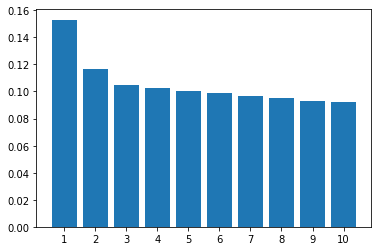

In [ ]:
clf = GridSearchCV(X_train, y_train, metric = 'euclidean')
accuracy = clf.findKNN()
clf.plot_accuracy()

In [ ]:
import operator
print(f'Оптимальное количество ближайших соседей при метрике "euclidean": {max(accuracy.items(), key=operator.itemgetter(1))}')

Оптимальное количество ближайших соседей при метрике "euclidean": (1, 0.5994350337298122)


Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

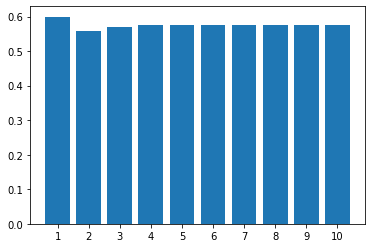

In [ ]:
X_train = TfidfVectorizer(max_features=50000).fit_transform(data)

clf = GridSearchCV(X_train, y_train, metric = 'cosine')
accuracy = clf.findKNN()
clf.plot_accuracy()

In [ ]:
print(f'Оптимальное количество ближайших соседей при метрике "euclidean": {max(accuracy.items(), key=operator.itemgetter(1))}')

Оптимальное количество ближайших соседей при метрике "euclidean": (1, 0.5994350337298122)


Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [ ]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [ ]:
my_clf = MyKNeighborsClassifier(n_neighbors = 1, metric = 'cosine')
my_clf.fit(X_train, y_train)
X_test, y_test = TfidfVectorizer(max_features=50000).fit_transform(newsgroups['data']) ,newsgroups['target']

In [ ]:
print(f"Accuracy : {accuracy_score(y_test, my_clf.predict(X_test,use_pairwise = True))}")

Accuracy : 0.048327137546468404


Возможно, качество отличается из-за работы алгоритма TfidfVectorizer. То есть, нет связи между TfidfVectorizer, который учился на data, и который учился newgroups. Признаки, на которых мы учились на data, на тестовой выборке представляют совсем другое.


# Линейные модели (5 баллов)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

### Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. 

Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [ ]:
from sklearn.utils import shuffle
def batch_generator(X, y, shuffle_state=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    n = X.shape[0]
    if shuffle_state:
      X, y = shuffle(X, y)
    for i in range(n // batch_size):
        yield (X[i:i + batch_size], y[i:i + batch_size])

In [233]:
#%%pycodestyle

def sigmoid(x):
  return 1 / (1 + np.exp(-x))


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='log_reg', batch_size = 100):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.batch_size = batch_size
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        m = X_batch.shape[0]
        predict = X_batch.dot(self.weights)
        L2 = 1 / self.C * np.square(self.weights).sum()
        if self.model_type == "lin_reg":
          loss = np.square(np.subtract(y_batch,predict)).mean() + L2
        elif self.model_type == "log_reg":
          #L(w)=−1N[∑iyilogai+(1−yi)log(1−ai)]+1CR(w)
          loss = -(y_batch*np.log(sigmoid(predict)) + (1 - y_batch)*np.log(1 - sigmoid(predict))).mean() + L2
        return loss
 
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        m = X_batch.shape[0]
        predict = X_batch.dot(self.weights)
        L2 = 2 / self.C * (self.weights)
        if self.model_type == 'lin_reg':
          loss_grad = (2 * (predict - y_batch).dot(X_batch) / m) + L2

        elif self.model_type == 'log_reg':
          loss_grad = ((sigmoid(predict) - y_batch).dot(X_batch) / m) + L2
        return loss_grad
   
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        
        self.weights -= self.alpha * new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        np.random.seed(2022)
        # Нужно инициализровать случайно весаw
        self.weights = np.random.normal(size = X.shape[1] + 1)
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, batch_size = self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                w0Vec = np.ones(new_batch[0].shape[0])[:, np.newaxis]
                X_batch = np.hstack((w0Vec, new_batch[0]))
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''

        w0Vec = np.ones(X.shape[0])[:, np.newaxis]
        X = np.hstack((w0Vec, X)) 
   
        y_hat = X.dot(self.weights)
        if self.model_type == "log_reg":
          y_hat = sigmoid(y_hat)
        y_hat = np.round(y_hat)
        return y_hat
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 


Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

Score Logistic Model : 0.8825
Weights : [-2.37369533  0.58343475 -0.48126278]
Score Linear Model : 0.8825
Weights : [ 0.01389562  0.12919326 -0.09423051]


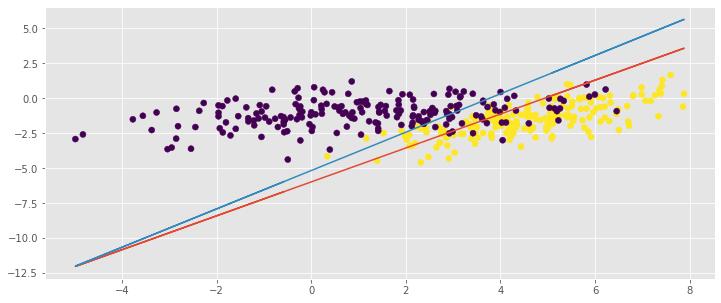

In [234]:
def plot_decision_boundary(w, X):
    ycords = (np.mean(y) - w[1]*X - w[0])/w[2]
    plt.plot(X, ycords)
    pass


C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

my_logistic  = MySGDClassifier(batch_generator=batch_generator, C =100,
                      max_epoch=100, model_type = "log_reg",
                      batch_size = 1)

my_linear = MySGDClassifier(batch_generator=batch_generator,
                      max_epoch=100, model_type = "lin_reg",
                      batch_size = 100)
my_logistic.fit(X, y)
my_linear.fit(X, y)


plot_decision_boundary(my_logistic.weights, X[:,0])
plot_decision_boundary(my_linear.weights, X[:,0])

plt.scatter(X[:,0], X[:,1], c=y)

print(f"Score Logistic Model : {my_logistic.score(X,y)}")
print(f"Weights : {my_logistic.weights}")

print(f"Score Linear Model : {my_linear.score(X,y)}")
print(f"Weights : {my_linear.weights}")



Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [235]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [241]:
alpha = np.array([0.1, 0.01, 0.4e-3, 0.9e-3, 0.1e-3, 0.5e-5])
N = 5
size = 100
loss_linear = np.zeros((len(alpha),size // N + 1))
for idx, item in enumerate(alpha):
  my_linear = MySGDClassifier(batch_generator=batch_generator,
                      alpha = item,max_epoch=500,
                      model_type = "lin_reg",
                      batch_size = size)
  my_linear.fit(X, y)
  loss_linear[idx][0] = my_linear.errors_log['loss'][0]
  for i in range(1,size // N + 1):
    loss_linear[idx][i] = np.mean(my_linear.errors_log['loss'][i*N:(i+1)*N])

  

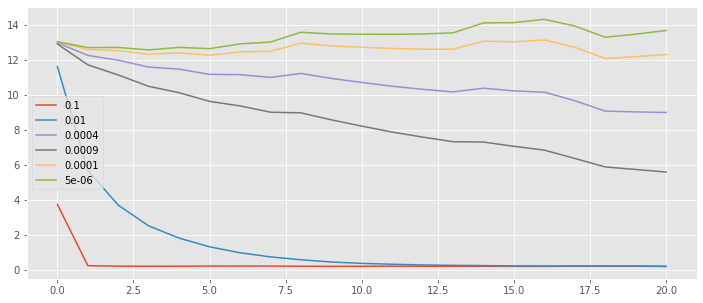

In [242]:

plt.plot(np.arange(size // N + 1), loss_linear.T)
plt.legend(alpha)


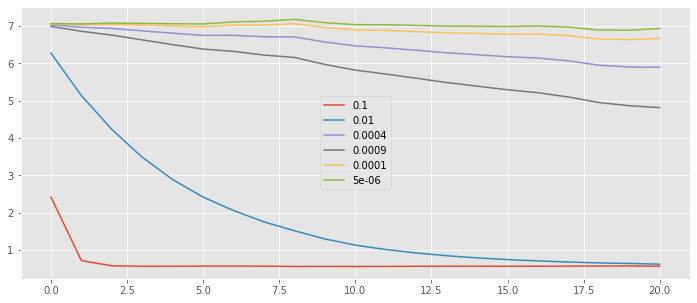

In [244]:

loss_logisitc = np.zeros((len(alpha),size // N + 1))
for idx, item in enumerate(alpha):
  my_logistic = MySGDClassifier(batch_generator=batch_generator,
                      alpha = item,max_epoch=500,
                      model_type = "log_reg",
                      batch_size = size)
  my_logistic.fit(X, y)
  loss_logisitc[idx][0] = my_logistic.errors_log['loss'][0]
  for i in range(size // N + 1):
    loss_logisitc[idx][i] = np.mean(my_logistic.errors_log['loss'][i*N:(i+1)*N])

  
plt.plot(np.arange(size // N + 1), loss_logisitc.T)
plt.legend(alpha)


Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

Ответ : На мой взгляд, нет определенного alpha, при котором модель будет сходиться идеально, поэтому я бы меня alpha по мере обучения (в сторону уменьшения)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

In [260]:
C_ = np.logspace(3,-3, 10)
w_mean_log = np.zeros(len(C_))
w_mean_lin = np.zeros(len(C_))
size = 100

for idx, item in enumerate(C_):
   my_logistic = MySGDClassifier(batch_generator=batch_generator,
                      C = item,
                      max_epoch=200,
                      model_type = "log_reg",
                      batch_size = size)
   
   my_linear = MySGDClassifier(batch_generator=batch_generator,
                      C = item,
                      max_epoch=200,
                      model_type = "lin_reg",
                      batch_size = size)
   
   my_logistic.fit(X, y)
   my_linear.fit(X, y)
   w_mean_log[idx] = my_logistic.weights.mean()
   w_mean_lin[idx] = my_linear.weights.mean()


w_mean_log = w_mean_log[:-2]
w_mean_lin = w_mean_lin[:-2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value 

Linear Regression


Text(0, 0.5, 'Weights mean')

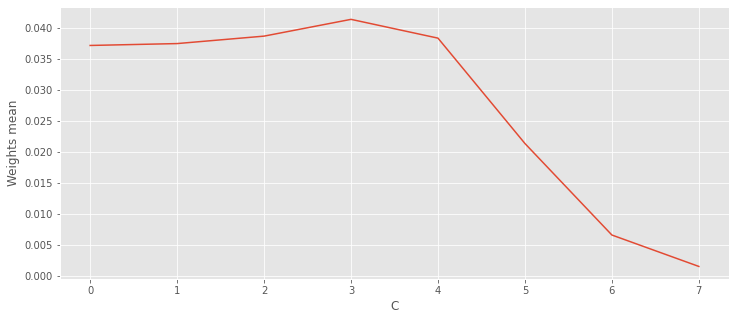

In [280]:
print(f"Linear Regression")
plt.plot(w_mean_lin)
plt.xlabel("C")
plt.ylabel("Weights mean")

Logistic Regression


Text(0, 0.5, 'Weights mean')

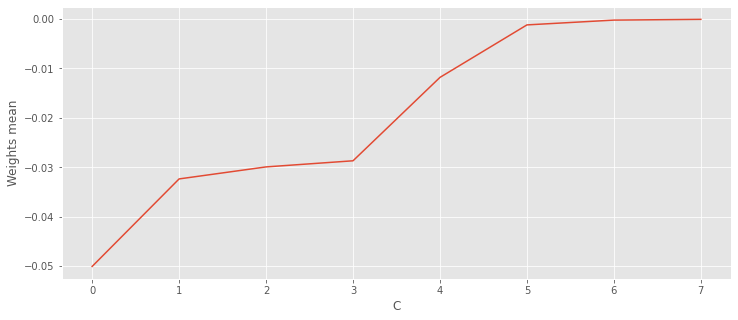

In [281]:
print(f"Logistic Regression")
plt.plot(w_mean_log)
plt.xlabel("C")
plt.ylabel("Weights mean")